In [ ]:
import os, sys
root_dir = os.path.dirname(os.getcwd())
sys.path.append(root_dir)

import pandas as pd
import matplotlib.pyplot as plt
from configs import support_llms, support_llm_properties
import numpy as np
import matplotlib as mpl
import seaborn as sns
from scipy import stats

df  = pd.read_pickle(f"{root_dir}/results/results.pkl")

df.head()

,_runtime,_step,_timestamp,_wandb,accuracy,calibrated_accuracy,consistency_rate,train_acc,seed,wandb,...,dataset_name,peft_variant,max_new_tokens,not_load_model,theory_example,theory_version,train_ml_model,system_prompt_name,run_name,run_id
0,608.820065,1999.0,1.733363e+09,{'runtime': 608},0.49750,0.0275,0.0600,NaN,42,True,...,relca,pretrained,1000,False,False,v4,,evaluator,fancy-rain-1,rws7x1ty
1,752.265414,1999.0,1.733364e+09,{'runtime': 752},0.51425,0.0760,0.1235,NaN,42,True,...,relca,pretrained,1000,False,False,v4,,evaluator,misty-frost-2,9n1ogm1l
2,5171.656271,1999.0,1.733368e+09,{'runtime': 5171},0.49675,0.0385,0.0405,NaN,42,True,...,relca,pretrained,1000,False,False,v4,,evaluator,denim-jazz-3,3qi1ixru
3,273.379546,1999.0,1.733363e+09,{'runtime': 273},0.60700,0.4520,0.6900,NaN,42,True,...,relca,pretrained,1000,False,False,v4,,evaluator,likely-yogurt-5,spxsot9y
4,1997.155615,1999.0,1.733365e+09,{'runtime': 1997},0.51175,0.0305,0.0375,NaN,42,True,...,relca,pretrained,1000,False,False,v4,,evaluator,exalted-resonance-6,8ixjdl3c


In [2]:
def get_row(**kwargs):
    condition = None
    for key, value in kwargs.items():

        if condition is None:
            condition = df[key] == value
        else:
            condition &= df[key] == value
    return df[condition].reset_index(drop=True)

# Standard, Multimodal, Pairwise

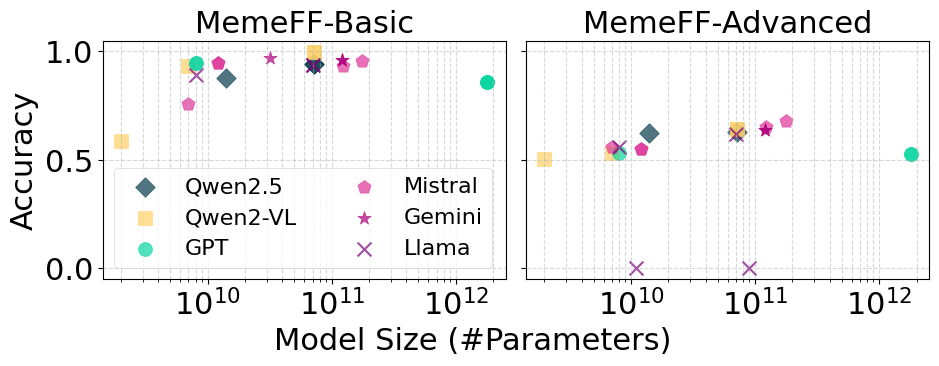

In [3]:
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.subplots_adjust(left=0.11, bottom=0.22, right=0.98, top=0.9, wspace=0.05) #margin of the figure
fig.set_size_inches(9.5, 3.5) #exact size of the figure

dataset_label = {
    'ours_v4': 'MemeFF-Basic',
    'relca_v2': 'MemeFF-Advanced'
}

for i, dataset_name in enumerate(['ours_v4', 'relca_v2']):
    smp_df = get_row(dataset_name=dataset_name, prompt_name='standard', eval_mode='pairwise', peft_variant = 'pretrained', n_demos = 0)

    plot_models = [model for model in smp_df['model_name'] if model in support_llm_properties and "model_size" in support_llm_properties[model]]

    # Group models by series
    qwen25_models = [m for m in plot_models if 'Qwen2.5' in m]
    qwen2vl_models = [m for m in plot_models if 'Qwen2-VL' in m]
    gpt_models = [m for m in plot_models if 'gpt' in m.lower()]
    mixtral_models = [m for m in plot_models if 'mixtral' in m.lower() or 'mistral' in m.lower() or 'pixtral' in m.lower()]
    gemini_models = [m for m in plot_models if 'gemini' in m.lower()]
    llama_models = [m for m in plot_models if 'llama' in m.lower()]
    other_models = [m for m in plot_models if m not in qwen25_models + qwen2vl_models + gpt_models + mixtral_models + gemini_models + llama_models]


    # Plot each series with different colors
    # '#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A'
    properties = {
        'qwen2.5': {'color': '#073B4C', 'marker': 'D'}, 
        'qwen2-vl': {'color': '#FFD166', 'marker': 's'}, 
        'gpt': {'color': '#06D6A0', 'marker': 'o'}, 
        'other': {'color': '#118AB2', 'marker': '^'},
        'mixtral': {'color': '#DD3497', 'marker': 'p'},
        'gemini': {'color': '#AE017E', 'marker': '*'},
        'llama': {'color': '#7A0177', 'marker': 'x'}
    }

    for models, color, marker, label in [
        (qwen25_models, properties['qwen2.5']['color'], properties['qwen2.5']['marker'], 'Qwen2.5'),
        (qwen2vl_models, properties['qwen2-vl']['color'], properties['qwen2-vl']['marker'], 'Qwen2-VL'),
        (gpt_models, properties['gpt']['color'], properties['gpt']['marker'], 'GPT'),
        (other_models, properties['other']['color'], properties['other']['marker'], 'Other'),
        (mixtral_models, properties['mixtral']['color'], properties['mixtral']['marker'], 'Mistral'),
        (gemini_models, properties['gemini']['color'], properties['gemini']['marker'], 'Gemini'),
        (llama_models, properties['llama']['color'], properties['llama']['marker'], 'Llama')
    ]:
        if models:
            x = [support_llm_properties[model]['model_size'] for model in models]
            y = [smp_df[smp_df['model_name'] == model]['accuracy'].values[0] for model in models]
            ax[i].scatter(x, y, alpha=0.7, s=100, c=color, label=label, marker=marker)

    # Set x-axis to logarithmic scale
    ax[i].set_xscale('log')

    if i == 0:
        ax[i].set_ylabel('Accuracy', fontsize=22)

    # Add grid lines
    ax[i].grid(True, which="both", ls="--", alpha=0.5)

    # Add legend
    if i == 0:
        ax[i].legend(fontsize=16, ncol=2, loc='lower left')
    ax[i].set_title(dataset_label[dataset_name], fontsize=22)

# # Annotate each point with the model name
# for model in plot_models:
#     x = support_llm_properties[model]['model_size']
#     y = smp_df[smp_df['model_name'] == model]['accuracy'].values[0]
#     if model in ["Qwen2-VL-7B-Instruct", "gpt-4o-mini"]:
#         ax.annotate(model, (x, y), xytext=(-5, 5), textcoords='offset points', fontsize=15, alpha=0.8, ha='right')
#     elif model in ["Mistral-Large-Instruct-2407", "Llama-3.1-70B-Instruct"]:
#         ax.annotate(model, (x, y), xytext=(5, -15), textcoords='offset points', fontsize=15, alpha=0.8)
#     else:
#         ax.annotate(model, (x, y), xytext=(5, 5), textcoords='offset points', fontsize=15, alpha=0.8)

# Adjust layout and display the plot
fig.supxlabel('Model Size (#Parameters)', fontsize=22, position=(0.5, 0))
# Save the figure as PDF
plt.savefig(f'{root_dir}/figures/model_size_vs_accuracy.pdf')


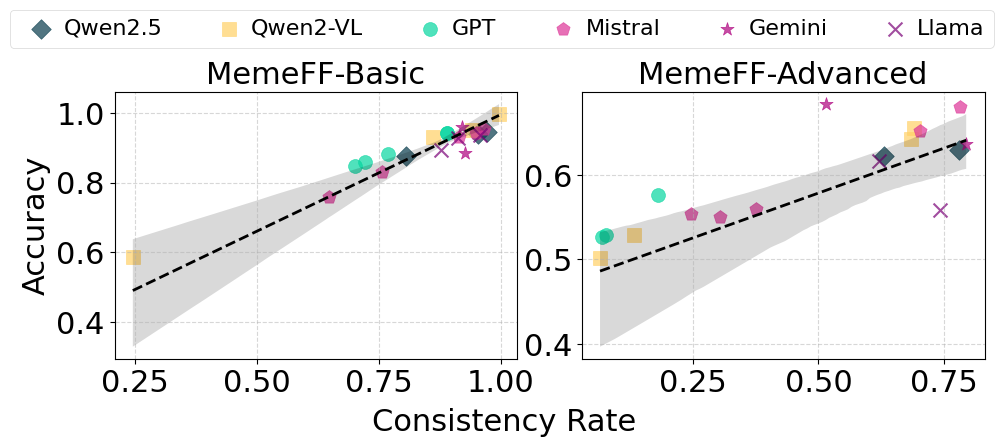

In [43]:
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.6))
fig.subplots_adjust(left=0.11, bottom=0.22, right=0.98, top=0.8, wspace=0.16) #margin of the figure

# Define datasets to plot
datasets_to_plot = ['ours_v4', 'relca_v2']
dataset_labels = {'ours_v4': 'MemeFF-Basic', 'relca_v2': 'MemeFF-Advanced'}

# Plot each dataset in its own subplot
for i, dataset in enumerate(datasets_to_plot):
    ax = axes[i]
    smp_df = get_row(dataset_name=dataset, prompt_name='standard', eval_mode='pairwise', peft_variant = 'pretrained', n_demos = 0)
    # Filter data for pairwise evaluation mode
    df_filtered = smp_df[(smp_df['dataset_name'] == dataset) & 
                         (smp_df['eval_mode'] == 'pairwise') & 
                         (smp_df['accuracy'] > 0)]  # Filter out cases where accuracy is 0
    
    if not df_filtered.empty:
        # For storing data points for regression in this subplot
        consistency_rates = df_filtered['consistency_rate'].values
        accuracies = df_filtered['accuracy'].values
        
        # Group models by type
        for model_group, color, marker, label in [
            (qwen25_models, properties['qwen2.5']['color'], properties['qwen2.5']['marker'], 'Qwen2.5'),
            (qwen2vl_models, properties['qwen2-vl']['color'], properties['qwen2-vl']['marker'], 'Qwen2-VL'),
            (gpt_models, properties['gpt']['color'], properties['gpt']['marker'], 'GPT'),
            (other_models, properties['other']['color'], properties['other']['marker'], 'Other'),
            (mixtral_models, properties['mixtral']['color'], properties['mixtral']['marker'], 'Mistral'),
            (gemini_models, properties['gemini']['color'], properties['gemini']['marker'], 'Gemini'),
            (llama_models, properties['llama']['color'], properties['llama']['marker'], 'Llama')
        ]:
            # Filter for models in this group
            group_df = df_filtered[df_filtered['model_name'].isin(model_group)]
            
            if not group_df.empty:
                ax.scatter(
                    group_df['consistency_rate'], 
                    group_df['accuracy'],
                    alpha=0.7,
                    s=100,
                    c=color,
                    marker=marker,
                    label=label
                )
        
        # Add regression line with confidence interval
        if len(consistency_rates) > 0:
            # Create a DataFrame for seaborn
            regression_df = pd.DataFrame({
                'consistency_rate': consistency_rates,
                'accuracy': accuracies
            })
            
            # Add regression line with confidence interval
            sns.regplot(
                x='consistency_rate', 
                y='accuracy', 
                data=regression_df,
                scatter=False,
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 2},
                ci=95,  # 95% confidence interval
                color='gray',
                ax=ax
            )
            
            # Calculate regression statistics
            slope, intercept, r_value, p_value, std_err = stats.linregress(consistency_rates, accuracies)
    
    # Add title
    ax.set_title(dataset_labels[dataset], fontsize=22)
    
    # Add grid lines
    ax.grid(True, which="both", ls="--", alpha=0.5)
    
    # Add x-label only to the first subplot
    if i == 0:
        ax.set_ylabel('Accuracy', fontsize=22)
    else:
        ax.set_ylabel('')
    
    # Remove x-label for this subplot
    ax.set_xlabel('')
    # Add legend only to the first subplot
    if i == 1:
        ax.legend(fontsize=16, ncol=6, bbox_to_anchor=(1.05, 1.35), handletextpad=0)

# Add common x-label
fig.supxlabel('Consistency Rate', fontsize=22, y=0.05)

# Save the figure
plt.savefig(f'{root_dir}/figures/consistency_vs_accuracy.pdf')
